In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

from allen_v1dd.client import OPhysClient, EMClient
from allen_v1dd.stimulus_analysis import analysis_tools as at
at.set_stylesheet()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
em_client = EMClient()
ophys_client = OPhysClient("/Users/chase/Desktop/test_v1dd_data")

/opt/anaconda3/envs/allen_v1dd/lib/python3.10/site-packages/standard_transform/datasets.py:24: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  rot, _ = R.align_vectors(np.array([[0, 1, 0]]), [up])


In [3]:
coreg = em_client.get_coregistration_table()
coreg.head()

,id_ref,created_ref,valid_ref,volume,pt_supervoxel_id,pt_root_id,id,created,valid,target_id,...,bb_end_position,ophys_session_id,ophys_plane,ophys_roi,roi,position_microns,axon_proof_status,axon_proof_complete,dendrite_proof_status,dendrite_proof_complete
0,277703,2022-02-04 06:24:15.742387+00:00,t,279.238104,92055099945612303,864691132710145793,1,2023-02-14 16:50:14.491563+00:00,t,277703,...,"[799901, 612885, 29027]",M409828_13,3,14,M409828_13_3_14,"[797.7329658575621, 268.4703958902916, 92.8290...",submitted,True,not_started,True
1,277515,2022-02-04 06:26:06.653170+00:00,t,329.847534,93180175218565442,864691132760377194,2,2023-02-14 16:50:14.492369+00:00,t,277515,...,"[840253, 582931, 28368]",M409828_13,1,60,M409828_13_1_60,"[838.0087061146714, 237.58057806602417, 93.975...",submitted,True,not_started,True
2,277213,2022-02-04 06:30:33.362739+00:00,t,313.577943,91843581329183083,864691132720617684,3,2023-02-14 16:50:14.493215+00:00,t,277213,...,"[791287, 598451, 26699]",M409828_13,2,30,M409828_13_2_30,"[790.0267659909371, 248.15872319569212, 76.111...",submitted,True,not_started,True
3,293528,2022-02-04 06:22:30.509490+00:00,t,332.374686,91070624654826905,864691132741334425,4,2023-02-14 16:50:14.494034+00:00,t,293528,...,"[764515, 637174, 26753]",M409828_13,5,119,M409828_13_5_119,"[763.2087486129211, 285.7899063229709, 65.5534...",submitted,True,submitted,True
4,277969,2022-02-04 06:21:54.350553+00:00,t,313.560871,92547337557612090,864691132771662867,5,2023-02-14 16:50:14.494820+00:00,t,277969,...,"[817050, 601866, 29619]",M409828_13,2,271,M409828_13_2_271,"[815.9190761795869, 258.40239635218177, 100.69...",submitted,True,not_started,True


In [4]:
# Load the corresponding 2P positions
coreg["ophys_pos"] = None

for idx, row in tqdm(coreg.iterrows(), total=len(coreg)):
    session = ophys_client.load_ophys_session(session_id=row.ophys_session_id)
    depth = session.get_plane_depth(plane=row.ophys_plane)
    y, x = np.mean(np.where(session.get_roi_image_mask(plane=row.ophys_plane, roi=row.ophys_roi)), axis=1) # note this is transposed
    coreg.at[idx, "ophys_pos"] = np.array([x, depth, y])

  0%|          | 0/51 [00:00<?, ?it/s]

(751.9179511334743, 939.4024606452016, -15.57742488917232, 171.42593037503343)

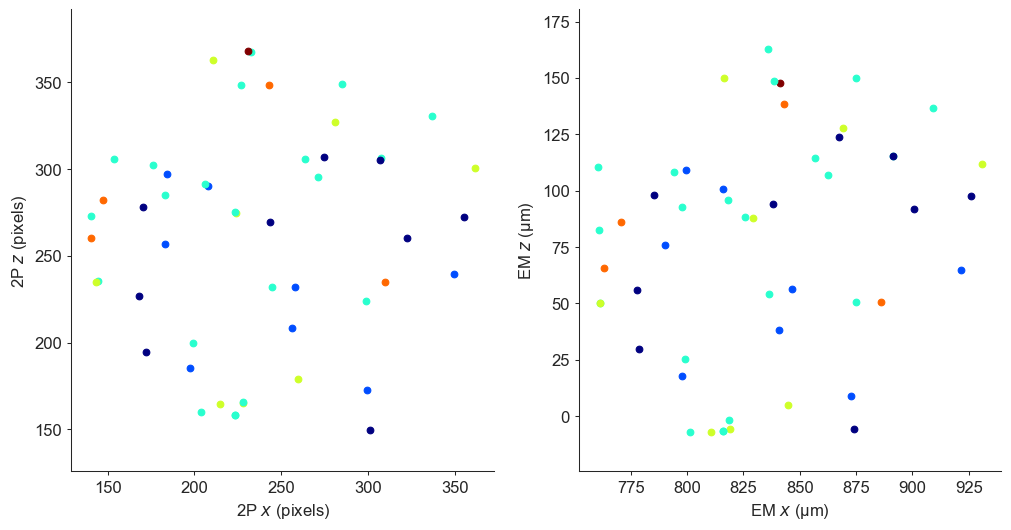

In [5]:
coreg_pts_microns = np.vstack(coreg.position_microns.values)
coreg_pts_ophys = np.vstack(coreg.ophys_pos.values)

fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
axs[0].set_xlabel("2P $x$ (pixels)")
axs[0].set_ylabel("2P $z$ (pixels)")
axs[1].set_xlabel("EM $x$ (µm)")
axs[1].set_ylabel("EM $z$ (µm)")

cmap = plt.get_cmap("jet")
cmap_norm = mpl.colors.Normalize(vmin=coreg_pts_ophys[:, 1].min(), vmax=coreg_pts_ophys[:, 1].max())

for i in range(len(coreg)):
    color = cmap(cmap_norm(coreg_pts_ophys[i, 1])) # scatter.get_facecolors()[0]

    axs[0].scatter(coreg_pts_ophys[i, 0], coreg_pts_ophys[i, 2], color=color)
    axs[1].scatter(coreg_pts_microns[i, 0], coreg_pts_microns[i, 2], color=color)

axs[0].axis("equal")
axs[1].axis("equal")

# fig.colorbar(axs[1])

# Fit a transformation going from 2P space to EM space
Let P be the matrix of all 2P locations, with rows (2P x, 2P depth, 2P z). Similarly let C be the matrix of EM "cortical" locations with rows (EM x, EM depth, EM z).

We aim to find 3x3 matrix X that minimizes PX = C. The corresponding normal equation is P'PX = P'C.

We also add a bias term to offset

In [6]:
# P = coreg_pts_ophys
P = np.column_stack((coreg_pts_ophys, np.ones(len(coreg_pts_microns))))
C = coreg_pts_microns
Pt = np.transpose(P)
X = np.linalg.solve(np.matmul(Pt, P), np.matmul(Pt, C))
X

array([[ 7.57540766e-01,  6.69402862e-02,  3.25446597e-02],
       [ 3.72289359e-03,  8.06254932e-01, -2.50998594e-01],
       [ 7.60522331e-02, -1.14233164e-02,  8.09780034e-01],
       [ 6.33308631e+02,  3.17737244e+01, -7.37477860e+01]])

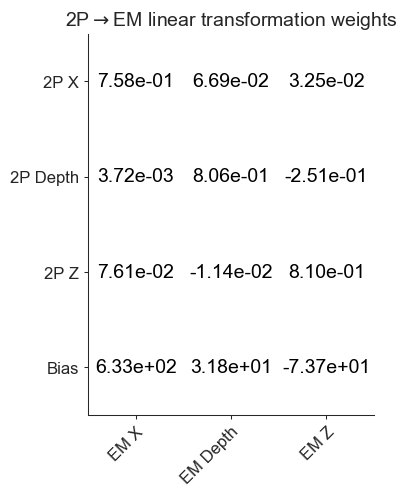

In [7]:
fig, ax = plt.subplots(figsize=(4, 6))

ax.imshow(X, cmap="hot_r", vmin=0, vmax=0) # make everything white

row_labels = ["2P X", "2P Depth", "2P Z", "Bias"]
col_labels = ["EM X", "EM Depth", "EM Z"]

ax.set_xticks(np.arange(len(col_labels)), labels=col_labels, rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(np.arange(len(row_labels)), labels=row_labels)

# Loop over data dimensions and create text annotations.
for i in range(len(row_labels)):
    for j in range(len(col_labels)):
        text = ax.text(j, i, f"{X[i, j]:.2e}", fontsize=14, ha="center", va="center", color="black")

ax.set_title("2P$\\rightarrow$EM linear transformation weights")
fig.tight_layout()

Text(0, 0.5, 'ROI count')

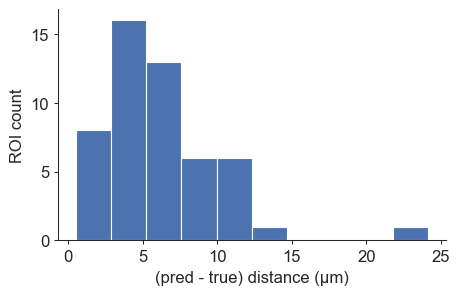

In [8]:
# Compute distance errors in microns
delta_microns = []
for i in range(len(coreg)):
    pi = P[i]
    ci_true = C[i]
    ci_pred = pi.dot(X)
    delta_microns.append(np.linalg.norm(ci_true - ci_pred))

plt.figure(figsize=(5, 3))
plt.hist(delta_microns)
plt.xlabel("(pred - true) distance (µm)")
plt.ylabel("ROI count")

(752.2865313565508, 939.7461286366644, -15.384095901488601, 171.1941099296427)

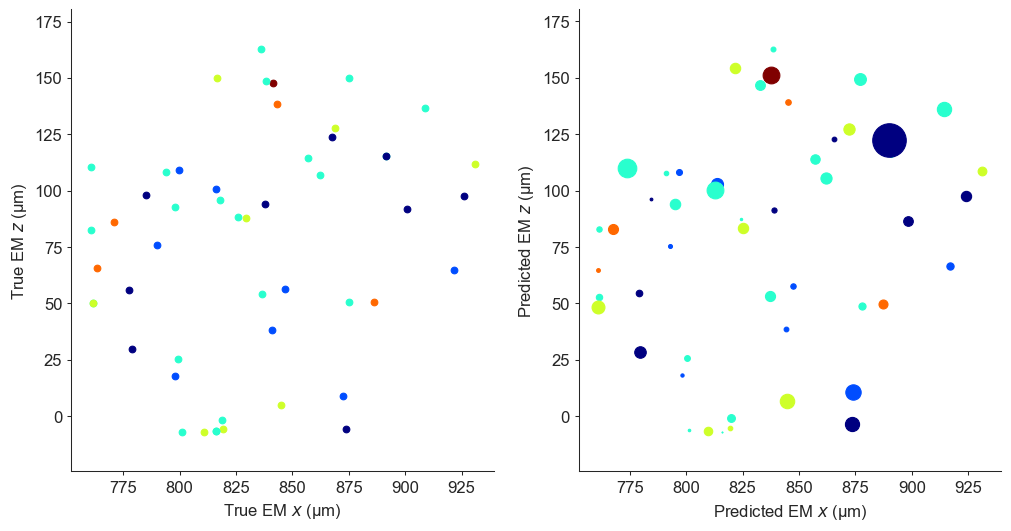

In [9]:
# Width (not area) of point is proportional to the prediction error in microns
fig, axs = plt.subplots(figsize=(12, 6), ncols=2)
axs[0].set_xlabel("True EM $x$ (µm)")
axs[0].set_ylabel("True EM $z$ (µm)")
axs[1].set_xlabel("Predicted EM $x$ (µm)")
axs[1].set_ylabel("Predicted EM $z$ (µm)")

cmap = plt.get_cmap("jet")
cmap_norm = mpl.colors.Normalize(vmin=coreg_pts_ophys[:, 1].min(), vmax=coreg_pts_ophys[:, 1].max())

for i in range(len(coreg)):
    pi = P[i]
    ci_true = C[i]
    ci_pred = pi.dot(X)
    delta_microns = np.linalg.norm(ci_true - ci_pred)
    color = cmap(cmap_norm(pi[1]))

    axs[0].scatter(ci_true[0], ci_true[2], color=color)
    # axs[1].scatter(ci_pred[0], ci_pred[2], color=color)
    axs[1].scatter(ci_pred[0], ci_pred[2], color=color, s=delta_microns**2)

axs[0].axis("equal")
axs[1].axis("equal")



(751.9007111151928, 939.76450102911, -15.57742488917232, 171.42593037503343)

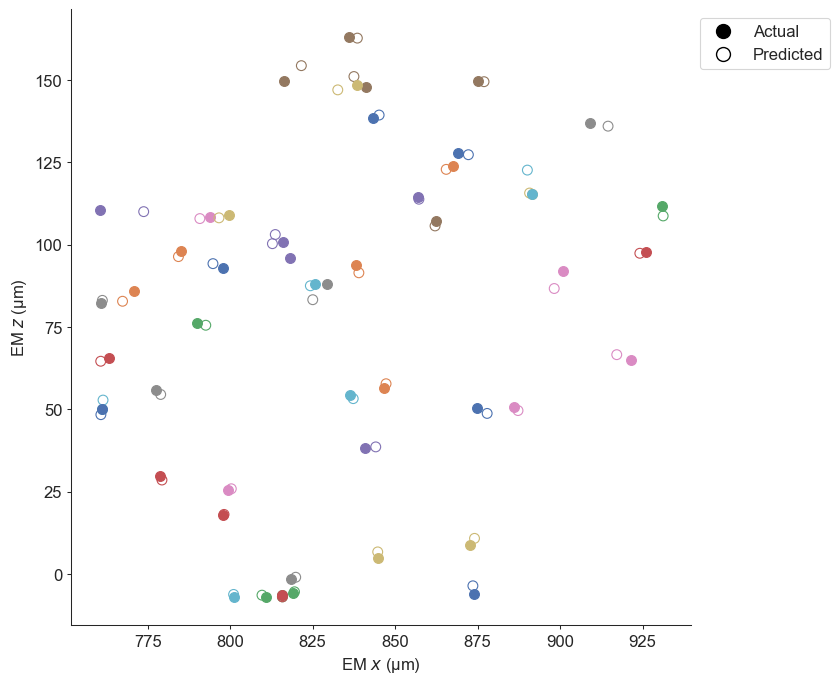

In [23]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel("EM $x$ (µm)")
ax.set_ylabel("EM $z$ (µm)")

# cmap = plt.get_cmap("jet")
# cmap_norm = mpl.colors.Normalize(vmin=coreg_pts_ophys[:, 1].min(), vmax=coreg_pts_ophys[:, 1].max())

for i in range(len(coreg)):
    pi = P[i]
    ci_true = C[i]
    ci_pred = pi.dot(X)
    delta_microns = np.linalg.norm(ci_true - ci_pred)
    color = cmap(cmap_norm(pi[1]))

    color = ax.scatter(ci_true[0], ci_true[2], s=50).get_facecolors()[0]
    ax.scatter(ci_pred[0], ci_pred[2], facecolors="none", edgecolors=color, s=50)

    # axs[0].scatter(ci_true[0], ci_true[2], color=color)
    # axs[1].scatter(ci_pred[0], ci_pred[2], color=color)
    # axs[1].scatter(ci_pred[0], ci_pred[2], color=color, s=delta_microns**2)

ax.legend(handles=[
    mpl.lines.Line2D([0], [0], label="Actual", marker="o", color="none", markerfacecolor="black", markersize=10),
    mpl.lines.Line2D([0], [0], label="Predicted", marker="o", color="none", markeredgecolor="black", markersize=10)
], loc="upper left", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)
ax.axis("equal")

# Plot column boundaries in EM (from Marc Takeno)

In [16]:
EM_CENTER = (212574, 5674)
EM_COLUMN_BOUNDS = {
	1: ((256581, 9733), (160660, 1772)),
	2: ((212015, 5637), (117303, 14196)),
	3: ((212574, 5674), (120280, -20)),
	4: ((212574, 5674), (305983, 14382)),
	5: ((212574, 5674), (303751, 129))
}

# Transform according to scale
for col, (bound_1, bound_2) in EM_COLUMN_BOUNDS.keys():
    EM_COLUMN_BOUNDS[key] = (())

COLUMN_COLORS = {
    1: 'r',
    2: 'g',
    3: 'b',
    4: 'm',
    5: 'k'
}

# (212574, 89829, 5674)				center
# (117675, 89829, 14270)				column 2 outside corner
# (213132, 89829, 14308)				column 2 - 4 common corner
# (119908, 89829, 5562)				column 2 - 3 common corner
# (305983, 89829, 14382)				column 4 outside corner
# (304123, 89829, 5748)				column 4 - 5 common corner

<AxesSubplot: >

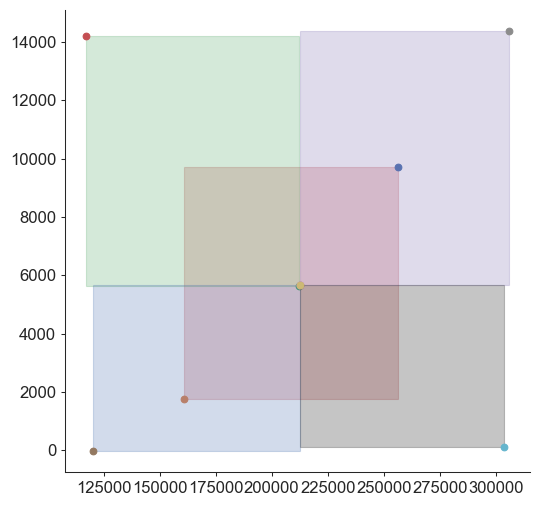

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))

for col, (bound_1, bound_2) in EM_COLUMN_BOUNDS.items():
    ax.add_artist(plt.Rectangle(xy=bound_1, width=(bound_2[0] - bound_1[0]), height=(bound_2[1] - bound_1[1]), color=COLUMN_COLORS[col], alpha=0.25))
    ax.scatter(*bound_1)
    ax.scatter(*bound_2)

# ax.legend()
ax.axis("equal")